<a href="https://colab.research.google.com/github/dr-kinder/playground/blob/dev/fenicsx_and_gmsh_gallery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Gallery of FEniCSx Examples

This document will, I hope, grow in time.  The goal is to provide some working examples of constructing models with gmsh + fenicsx and analyzing the results of a finite element calculation.

# Install and Import

These three cells will install and import the packages required to run these examples — i.e., those that are not already part of CoLab's Python environment.

You can run the cells multiple times.  The installation only happens once, so don't hesitate to reset the kernel or restart the runtime.

In [ ]:
try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [ ]:
try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [ ]:
try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

In [5]:
# Everything should be installed now.
# Import the rest of what we need, with nicknames that are easier to type.

import dolfinx.fem as df
import dolfinx.mesh as dm
from dolfinx.io import gmshio
import mpi4py.MPI as mpi
import petsc4py.PETSc as petsc
import ufl

import numpy as np
import multiphenicsx.io as mpio

# Dielectric Rod

This section will create a 2D cross section of a dielectric cylinder inside a rectangular pipe.  The walls of the pipe can be held at separate potentials.

When the box is large and the dielectric wire is small, the system starts to approximate a dielectric in a uniform background field.


In [6]:
# -----------------------------------------------------------------------------
# Define geometry.
# ----------------------------------------------------------------------------- 
# Define the dimension of the model.
dim = 2

# Define material properties.
epsilon0 = 1
epsilon1 = 300

# Define the center of the universe.
x0 = 0
y0 = 0
z0 = 0

# Define the rectangle.
L = 4
W = 8

# Define the circle.
dX = 0.0
dY = 0.0
rX = 0.5
rY = 0.5

# Grid size parameter.  Make it smaller for higher resolution.
delta = 0.125

In [7]:
# -----------------------------------------------------------------------------
# Create the model.
# ----------------------------------------------------------------------------- 
gmsh.initialize()
gmsh.model.add("mesh")

model = gmsh.model
geo = gmsh.model.geo

## Define rectangle.
# Corners
p0 = geo.addPoint(x0-L/2, y0-W/2, z0, delta)
p1 = geo.addPoint(x0+L/2, y0-W/2, z0, delta)
p2 = geo.addPoint(x0+L/2, y0+W/2, z0, delta)
p3 = geo.addPoint(x0-L/2, y0+W/2, z0, delta)

# Edges
l0 = geo.addLine(p0, p1)
l1 = geo.addLine(p1, p2)
l2 = geo.addLine(p2, p3)
l3 = geo.addLine(p3, p0)
perimeter = geo.addCurveLoop([l0, l1, l2, l3])

## Define disk.
# Define points: center of circle and two points on opposite sides.
c0 = geo.addPoint(x0+dX, y0+dY, z0, delta)
c1 = geo.addPoint(x0+dX, y0+dY-rY, z0, delta)
c2 = geo.addPoint(x0+dX, y0+dY+rY, z0, delta)

# Define two semicircular arcs that will be joined into a circle.
s0 = geo.addCircleArc(c1, c0, c2)
s1 = geo.addCircleArc(c2, c0, c1)
circumference = geo.addCurveLoop([s0, s1])

## Define objects.
# The "background" is a rectangle with a hole.
rectangle = geo.addPlaneSurface([perimeter, circumference])

# The object fills the hole.
circle = geo.addPlaneSurface([circumference])

# Update the model with all of the features we added.
geo.synchronize()

# Identify the physical objects: boundaries and surfaces.
# Add the edges separately, so boundary conditions can be set individually.
model.addPhysicalGroup(1, [l0], 1)
model.addPhysicalGroup(1, [l1], 2)
model.addPhysicalGroup(1, [l2], 3)
model.addPhysicalGroup(1, [l3], 4)
model.addPhysicalGroup(2, [rectangle], 1)

# Add the circle and its boundaries.
model.addPhysicalGroup(1, [c0,c1], 5)
model.addPhysicalGroup(2, [circle], 5)

# Create a mesh for this system.
model.mesh.generate(dim)

# Bring the mesh into FEniCSx.
mesh, subdomains, boundaries = gmshio.model_to_mesh(
    model, comm=mpi.COMM_WORLD, rank=0, gdim=2)

# Close the mesh generating program.
gmsh.finalize()

In [8]:
# Plot the entire mesh.
mpio.plot_mesh(mesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [9]:
# Plot the subdomains that FEniCSx has identified.
mpio.plot_mesh_tags(subdomains)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [10]:
# -----------------------------------------------------------------------------
# Boundary Conditions
# ----------------------------------------------------------------------------- 

# Set the potential on each wall.
# The two ends will be fixed.  The two sides will be open.
V1 = 2.0
V2 = 0.0
V3 = 0.0
V4 = 0.0

# Define the type of boundary on each wall.
# Set to "True" or "1" for essential (fixed potential).
# Set to "False" or "0" for natural (zero normal derivative).
essential_1 = True
essential_2 = False
essential_3 = True
essential_4 = False

In [11]:
# -----------------------------------------------------------------------------
# Material Properties
# ----------------------------------------------------------------------------- 
# Define a simple function space for properties.
Q = df.FunctionSpace(mesh, ("DG", 0))

# Get the catalog of materials.
material_tags = np.unique(subdomains.values)

# Define function for permittivity.
epsilon = df.Function(Q)

# Now, cycle over all objects and assign material properties. 
for tag in material_tags:
    cells = subdomains.find(tag)
    
    # Set values for magnetic permeability.
    if tag == 1:
        # Vacuum
        eps_ = epsilon0
    elif tag == 5:
        # Dielectric
        eps_ = epsilon1
    else:
        # Anything else
        eps_ = epsilon0

    epsilon.x.array[cells] = np.full_like(cells, eps_, dtype=petsc.ScalarType)

In [12]:
# -----------------------------------------------------------------------------
# Finite Element Analysis
# ----------------------------------------------------------------------------- 

# Define trial and test functions.
V = df.FunctionSpace(mesh, ("Lagrange", 2))

# Define the trial and test functions.
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Create a function to store the solution.
phi = df.Function(V)

# Identify the domain (all the points inside the boundary).
Omega = subdomains.indices[subdomains.values == 1]

# Identify the boundary for FEniCSx.
wall_1 = boundaries.indices[boundaries.values == 1]
wall_2 = boundaries.indices[boundaries.values == 2]
wall_3 = boundaries.indices[boundaries.values == 3]
wall_4 = boundaries.indices[boundaries.values == 4]
dOmega_1 = df.locate_dofs_topological(V, boundaries.dim, wall_1)
dOmega_2 = df.locate_dofs_topological(V, boundaries.dim, wall_2)
dOmega_3 = df.locate_dofs_topological(V, boundaries.dim, wall_3)
dOmega_4 = df.locate_dofs_topological(V, boundaries.dim, wall_4)

# Now introduce the boundary conditions.
# Store the essential boundary conditions in a list.
essential_bc = []
if essential_1:
    Phi0 = df.Constant(mesh, petsc.ScalarType(V1))
    essential_bc += [df.dirichletbc(Phi0, dOmega_1, V)]
if essential_2:
    Phi0 = df.Constant(mesh, petsc.ScalarType(V2))
    essential_bc += [df.dirichletbc(Phi0, dOmega_2, V)]
if essential_3:
    Phi0 = df.Constant(mesh, petsc.ScalarType(V3))
    essential_bc += [df.dirichletbc(Phi0, dOmega_3, V)]
if essential_4:
    Phi0 = df.Constant(mesh, petsc.ScalarType(V4))
    essential_bc += [df.dirichletbc(Phi0, dOmega_4, V)]

# This is the FEM version of the Laplacian.
# It is the left-hand side of Poisson's or Laplace's equation.
a = epsilon * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

# This the right-hand side of Poisson's equation.
# We need to create a FEniCSx-friendly version of 0.
Zero = df.Constant(mesh, petsc.ScalarType(0.0))
L = Zero * v * ufl.dx

# Put it all together for FEniCSx.
problem = df.petsc.LinearProblem(a, L, essential_bc, u=phi)

# Now, solve it!
problem.solve()

# Tie up some loose ends.
phi.vector.ghostUpdate(addv=petsc.InsertMode.INSERT, mode=petsc.ScatterMode.FORWARD)

# Define a set of elements for a vector field.
W = df.VectorFunctionSpace(mesh, ("Lagrange", 2))
E = df.Function(W)

# Compute the gradient as a symbolic expression, then interpolate it onto the mesh.
expr = df.Expression(ufl.as_vector((-phi.dx(0), -phi.dx(1))), W.element.interpolation_points())
E.interpolate(expr)

In [13]:
# Plot the potential.
mpio.plot_scalar_field(phi, "Potential", warp_factor=1)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [14]:
# Use multiphenics to plot the vector field.
mpio.plot_vector_field(E,name="Electric Field", glyph_factor=0.2)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Dielectric Sphere

This script will create a dielectric sphere inside of a rectangular box.

When the box is large and the sphere is small, the system starts to approximate a dielectric in a uniform background field.


In [15]:
# -----------------------------------------------------------------------------
# Define geometry.
# ----------------------------------------------------------------------------- 
# Define the dimension of the model.
dim = 3

# Define material properties.
epsilon1 = 1
epsilon2 = 3

# Define the center of the universe.
x0 = 0
y0 = 0
z0 = 0

# Define the box size.
L = 4
W = 4
H = 8

# Define the sphere: offset and radius.
dX = 0.0
dY = 0.0
dZ = 0.0
R = 1.0

# Grid size parameter.  Make it smaller for higher resolution.
delta = 0.25

In [16]:
# -----------------------------------------------------------------------------
# Create the model.
# ----------------------------------------------------------------------------- 
gmsh.initialize()
gmsh.model.add("mesh")

model = gmsh.model
occ = gmsh.model.occ

## Add the sphere and the box to the model.
sphere = occ.addSphere(x0+dX, y0+dY, z0+dZ, R)
box = occ.addBox(x0-L/2, y0-W/2, z0-H/2, L, W, H)

## Merge them together.
universe = gmsh.model.occ.fragment([(3, box)], [(3,sphere)])

# Update the model with all of the features we added.
occ.synchronize()

## Identify the box and sphere as distinct physical objects.
for thing in universe[0]:
    mass = occ.getMass(thing[0], thing[1])
    if np.isclose(mass, 4/3*np.pi*R**3):
        model.addPhysicalGroup(thing[0], [thing[1]], tag=2)
    else:
        model.addPhysicalGroup(thing[0], [thing[1]], tag=1)

# Now add the surfaces to the model.
# Label the front and back walls, so we can set the potential.
surfaces = occ.getEntities(dim=2)
others = []
for s in surfaces:
    center = occ.getCenterOfMass(s[0], s[1])
    if np.allclose(center, [0, 0, -H/2]):
        model.addPhysicalGroup(s[0], [s[1]], 1)
    elif np.allclose(center, [0, 0, H/2]):
        model.addPhysicalGroup(s[0], [s[1]], 2)
    else:
        others += [s[1]]
# model.addPhysicalGroup(2, others, 3)

# Set a uniform mesh size.
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), delta)

# Create a mesh for this system.
model.mesh.generate(dim)

# Bring the mesh into FEniCSx.
mesh, subdomains, boundaries = gmshio.model_to_mesh(
    model, comm=mpi.COMM_WORLD, rank=0, gdim=dim)

# Close the mesh generating program.
gmsh.finalize()

(2, 1) (-4.591795826291087e-17, 2.5509114760825052e-18, 1.734723475976807e-17)
(2, 2) (-2.0, 1.1102230246251565e-16, 9.71445146547012e-17)
(2, 3) (4.163336342344337e-17, -2.0, 9.71445146547012e-17)
(2, 4) (4.85722573273506e-17, 4.163336342344337e-17, 4.0)
(2, 5) (4.163336342344337e-17, 2.0, 9.71445146547012e-17)
(2, 6) (4.85722573273506e-17, 4.163336342344337e-17, -4.0)
(2, 7) (2.0, 1.1102230246251565e-16, 9.71445146547012e-17)


In [17]:
# -----------------------------------------------------------------------------
# Boundary Conditions
# ----------------------------------------------------------------------------- 
# Set the potential on the end walls.
V1 = 2.0
V2 = 0.0

In [18]:
# -----------------------------------------------------------------------------
# Material Properties
# ----------------------------------------------------------------------------- 
# Define a simple function space for properties.
Q = df.FunctionSpace(mesh, ("DG", 0))

# Get the catalog of materials.
material_tags = np.unique(subdomains.values)

# Define function for permittivity.
epsilon = df.Function(Q)

# Now, cycle over all objects and assign material properties. 
for tag in material_tags:
    cells = subdomains.find(tag)
    
    # Set values for magnetic permeability.
    if tag == 1:
        # Vacuum
        eps_ = epsilon1
    elif tag == 2:
        # Dielectric
        eps_ = epsilon2
    else:
        # Anything else
        eps_ = 1

    epsilon.x.array[cells] = np.full_like(cells, eps_, dtype=petsc.ScalarType)

In [19]:
# -----------------------------------------------------------------------------
# Finite Element Analysis
# ----------------------------------------------------------------------------- 

# Define trial and test functions.
V = df.FunctionSpace(mesh, ("Lagrange", 2))

# Define the trial and test functions.
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Create a function to store the solution.
phi = df.Function(V)

# Identify the domain (all the points inside the boundary).
Omega = subdomains.indices[subdomains.values == 1]

# Identify the boundary for FEniCSx.
wall_1 = boundaries.indices[boundaries.values == 1]
wall_2 = boundaries.indices[boundaries.values == 2]
dOmega_1 = df.locate_dofs_topological(V, boundaries.dim, wall_1)
dOmega_2 = df.locate_dofs_topological(V, boundaries.dim, wall_2)

# Now introduce the boundary conditions.
# Store the essential boundary conditions in a list.
essential_bc = []
Phi0 = df.Constant(mesh, petsc.ScalarType(V1))
essential_bc += [df.dirichletbc(Phi0, dOmega_1, V)]
Phi0 = df.Constant(mesh, petsc.ScalarType(V2))
essential_bc += [df.dirichletbc(Phi0, dOmega_2, V)]

# This is the FEM version of the Laplacian.
# It is the left-hand side of Poisson's or Laplace's equation.
a = epsilon * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

# This the right-hand side of Poisson's equation.
# We need to create a FEniCSx-friendly version of 0.
Zero = df.Constant(mesh, petsc.ScalarType(0.0))
L = Zero * v * ufl.dx

# Put it all together for FEniCSx.
problem = df.petsc.LinearProblem(a, L, essential_bc, u=phi)

# Now, solve it!
problem.solve()

# Tie up some loose ends.
phi.vector.ghostUpdate(addv=petsc.InsertMode.INSERT, mode=petsc.ScatterMode.FORWARD)

# Define a set of elements for a vector field.
W = df.VectorFunctionSpace(mesh, ("Lagrange", 2))
E = df.Function(W)

# Compute the gradient as a symbolic expression, then interpolate it onto the mesh.
expr = df.Expression(ufl.as_vector((-phi.dx(0), -phi.dx(1), -phi.dx(2))), W.element.interpolation_points())
E.interpolate(expr)

In [23]:
# Plot the potential.
mpio.plot_scalar_field(phi, "Potential", warp_factor=0)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [21]:

# Use multiphenics to plot the vector field.
mpio.plot_vector_field(E,name="Electric Field", glyph_factor=1)


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Importing Data into NumPy

The following commands will extract the numerical data generated by fenicsx and process it with the fammiliar tools of NumPy and matplotlib.

In [24]:
# fenicsx stores data its own way, but it is accessible.
# To get coordinates, use the FunctionSpace.

coordinates = W.tabulate_dof_coordinates()
x = coordinates[:,0]
y = coordinates[:,1]
z = coordinates[:,2]

# The array values --- in this case, the values of the electric field ---
# are in the object, not the function space.
# It is a 1D array, so we need to reshape it.
e_vals = E.x.array.reshape(-1,3)
ex = e_vals[:,0]
ey = e_vals[:,1]
ez = e_vals[:,2]

In [25]:
# There are a LOT of points.
# Keep this in mind when plotting.
x.shape

(55285,)

In [26]:
# The points are in the order that fenicsx labeled them,
# so scatter plots will provide more information than lines.

# Look inside the sphere.
inside = (x**2 + y**2 + z**2) < R**2

# Number of points to skip in generating plots.
n = 10

In [27]:
# Import the workhorse libraries.
import numpy as np
import matplotlib.pyplot as plt

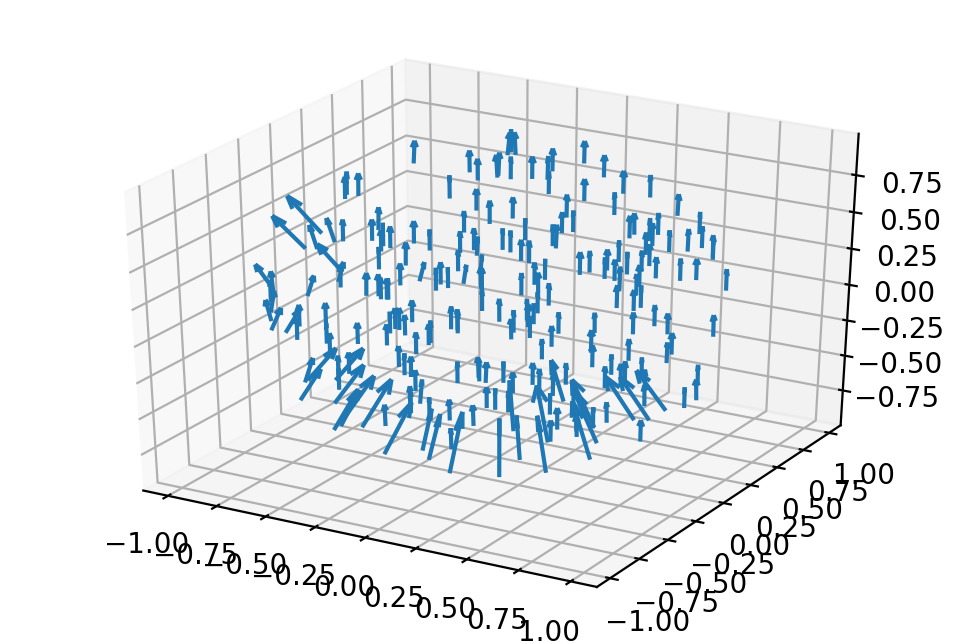

In [32]:
# Plot the field inside the sphere.
plt.figure(dpi=200)
ax = plt.subplot(projection='3d')
ax.quiver3D(x[inside][::n], y[inside][::n], z[inside][::n], ex[inside][::n], ey[inside][::n], ez[inside][::n])
plt.show()

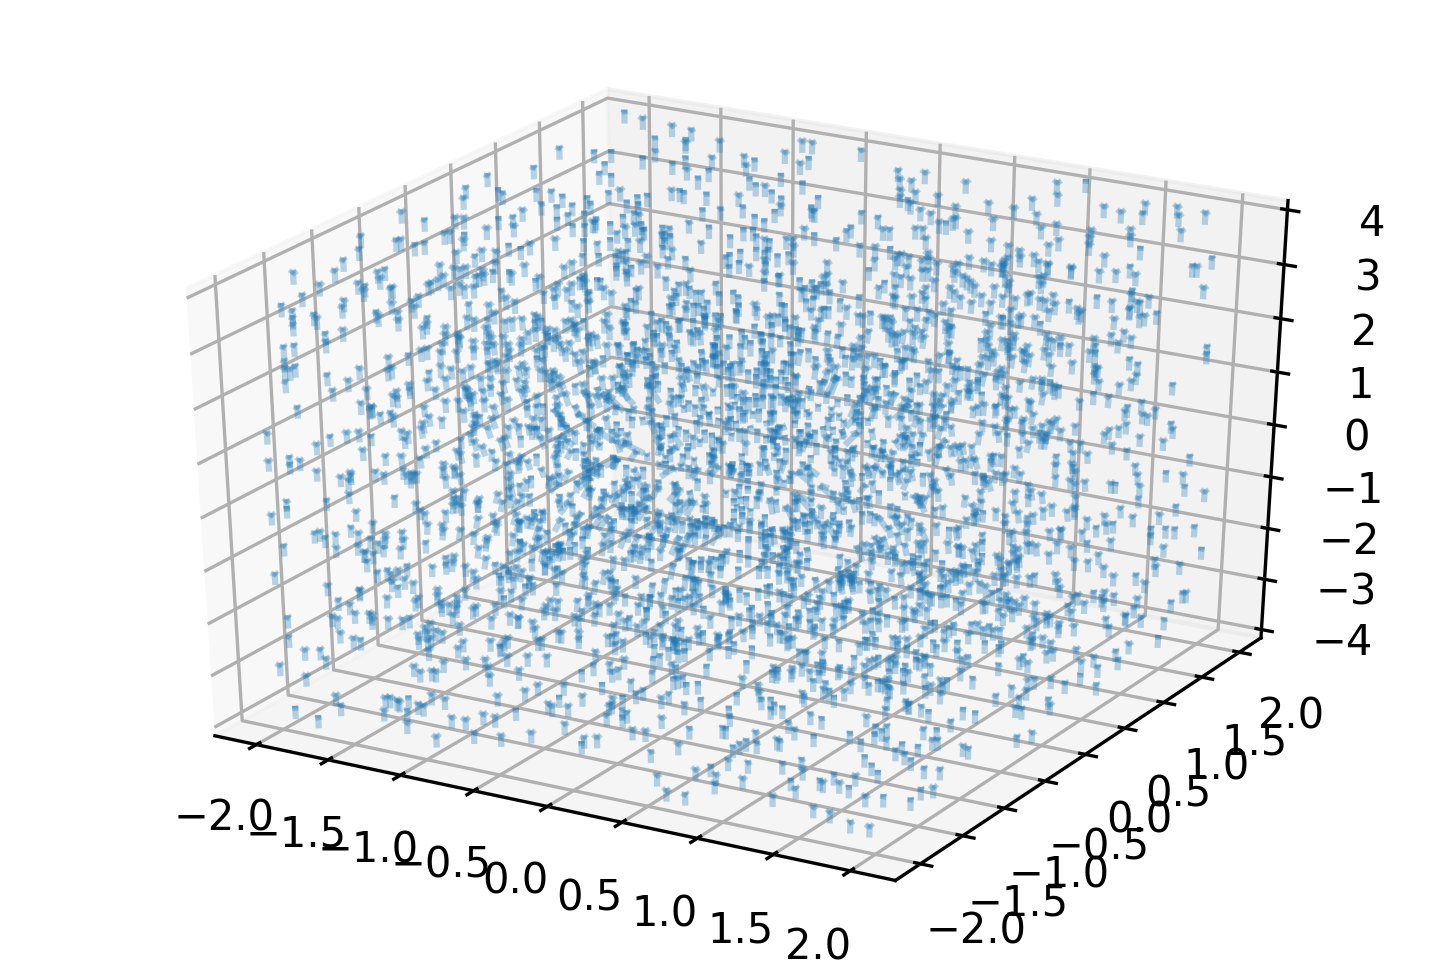

In [37]:
# Plot all of the points.
n = 20
plt.figure(dpi=300)
ax = plt.subplot(projection='3d')
ax.quiver3D(x[::n], y[::n], z[::n], ex[::n], ey[::n], ez[::n],alpha=0.3)
plt.show()

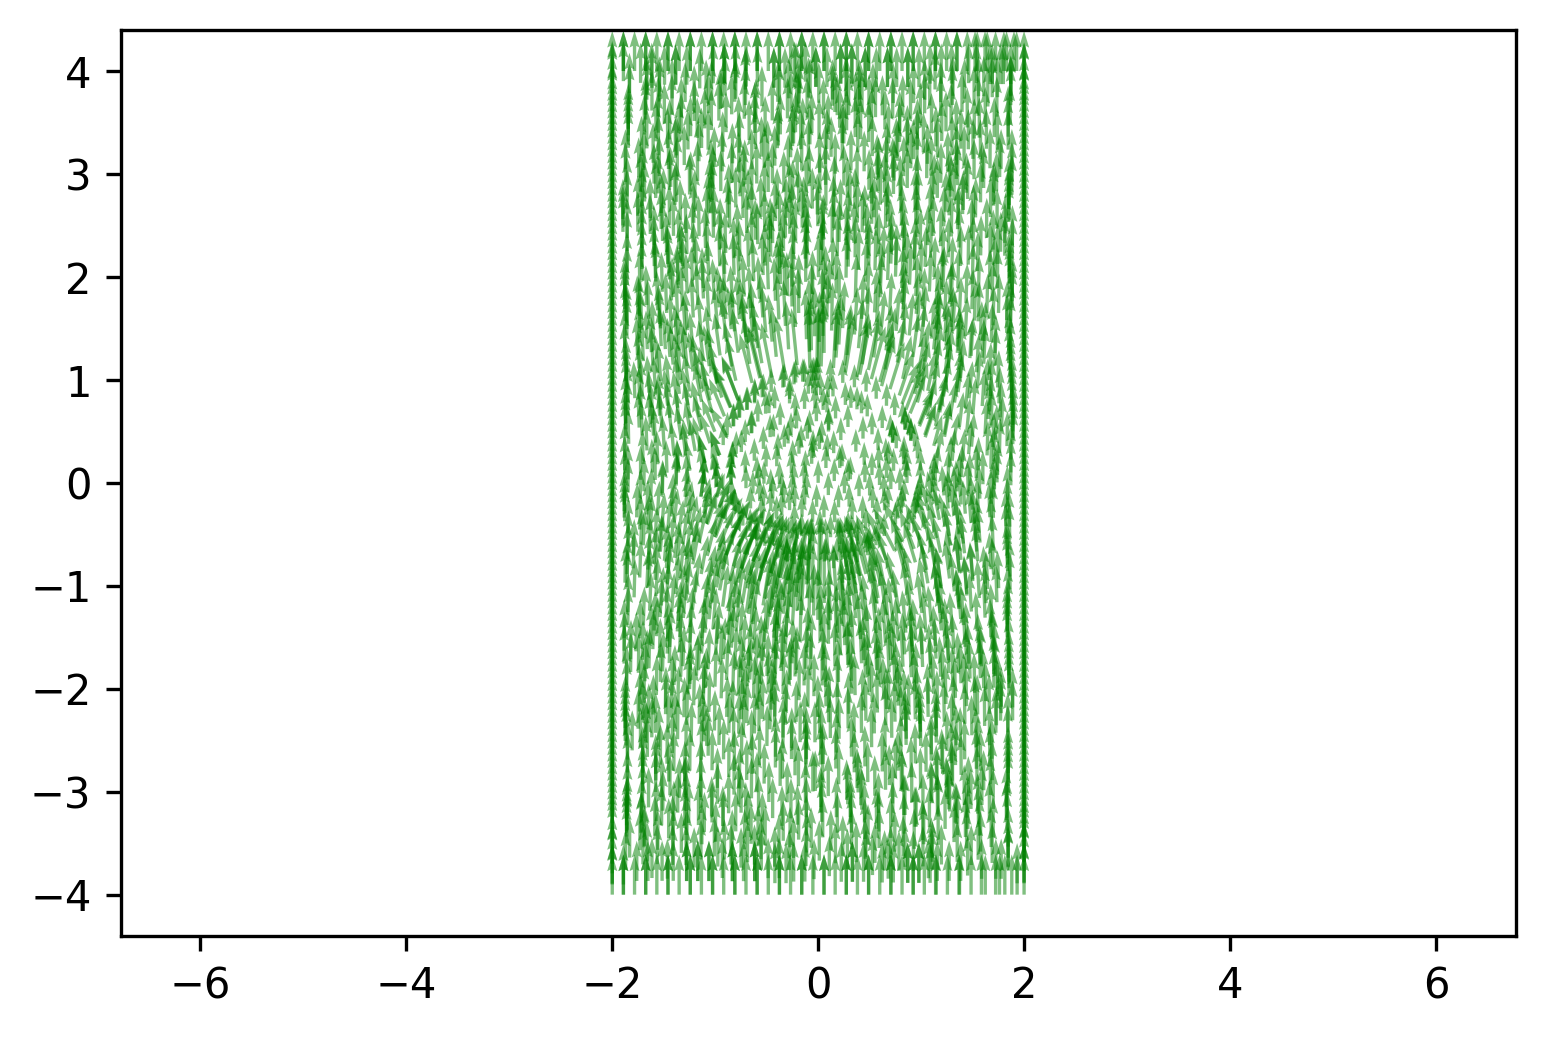

In [56]:
# Try to look at a slice through the y=0 plane.
# This will identify the points close to y=0.
# It is a boolean array that can be used to index
# other arrays.
view = np.isclose(y,0,atol=0.1)
plt.figure(dpi=300)
plt.quiver(x[view], z[view], ex[view], ez[view], scale=9, alpha=0.5, color='green')
plt.axis('equal');